In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Load the data
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

# 1. Data Cleaning
def clean_data(df):
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # Remove duplicates
    df_imputed = df_imputed.drop_duplicates()

    # Handle outliers (using IQR method for Amount)
    Q1 = df_imputed['Amount'].quantile(0.25)
    Q3 = df_imputed['Amount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_imputed['Amount'] = df_imputed['Amount'].clip(lower_bound, upper_bound)

    return df_imputed

# 2. Data Transformation
def transform_data(df):
    # Normalize numerical features
    scaler = StandardScaler()
    numerical_features = ['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)]
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    # Create time-based features
    df['Hour'] = df['Time'].apply(lambda x: (x / 3600) % 24)
    df['Day'] = df['Time'].apply(lambda x: (x / 86400) % 7)

    return df

# 3. Feature Engineering
def engineer_features(df):
    # Create a feature for transaction frequency per card
    df['TransactionFreq'] = df.groupby('V1')['Time'].transform('count')

    # Create a feature for average transaction amount per card
    df['AvgAmount'] = df.groupby('V1')['Amount'].transform('mean')

    return df

# 4. Handle Imbalanced Data
def balance_data(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# 5. Data Splitting
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Main preprocessing pipeline
def preprocess_data(df):
    print("Original shape:", df.shape)

    # Clean data
    df_cleaned = clean_data(df)
    print("Shape after cleaning:", df_cleaned.shape)

    # Transform data
    df_transformed = transform_data(df_cleaned)
    print("Shape after transformation:", df_transformed.shape)

    # Engineer features
    df_engineered = engineer_features(df_transformed)
    print("Shape after feature engineering:", df_engineered.shape)

    # Prepare for modelling
    X = df_engineered.drop(['Class'], axis=1)
    y = df_engineered['Class']

    # Balance data
    X_resampled, y_resampled = balance_data(X, y)
    print("Shape after balancing:", X_resampled.shape)

    # Split data
    X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled)
    print("Training set shape:", X_train.shape)
    print("Testing set shape:", X_test.shape)

    return X_train, X_test, y_train, y_test

# Run the preprocessing pipeline
X_train, X_test, y_train, y_test = preprocess_data(df)

print("\nPreprocessing completed. Data is now ready for modelling.")

Original shape: (284807, 31)
Shape after cleaning: (283726, 31)
Shape after transformation: (283726, 33)
Shape after feature engineering: (283726, 35)
Shape after balancing: (566506, 34)
Training set shape: (453204, 34)
Testing set shape: (113302, 34)

Preprocessing completed. Data is now ready for modelling.


In [2]:
# Save the training and testing data to CSV files
X_train.to_csv('/content/drive/MyDrive/X_train.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/X_test.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/y_train.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/y_test.csv', index=False)

print("\nTraining and testing data saved to Google Drive.")


Training and testing data saved to Google Drive.


Top 10 features selected by ANOVA F-value:
['V2', 'V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Top 10 features selected by RFE:
['V4', 'V8', 'V10', 'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'TransactionFreq']

Top 10 features selected by Random Forest Importance:
['V14', 'V12', 'V10', 'V4', 'V11', 'V17', 'V16', 'V3', 'V7', 'V21']


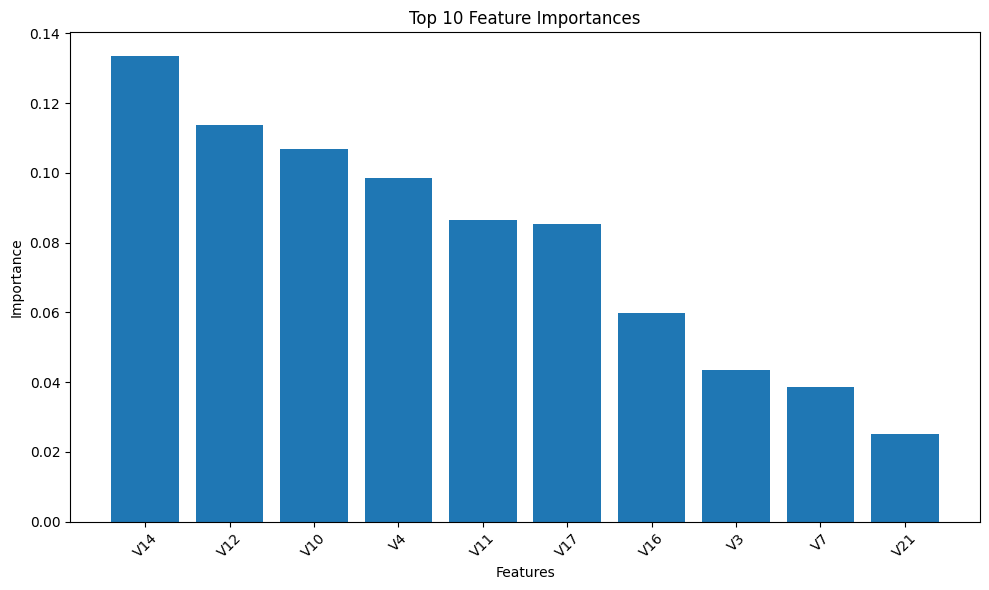

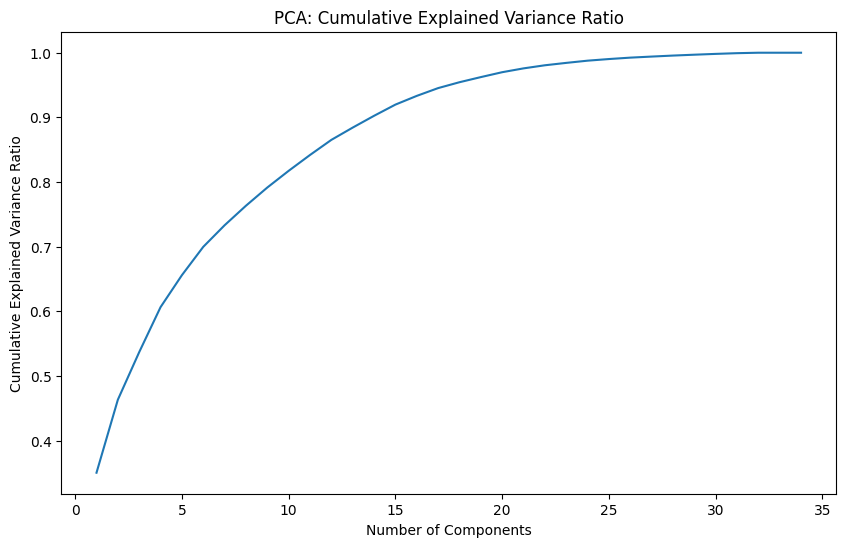


Number of components explaining 95% of variance: 18

Mean ROC AUC for Filter method: 1.0000 (+/- 0.0000)

Mean ROC AUC for Wrapper method: 1.0000 (+/- 0.0000)

Mean ROC AUC for Embedded method: 1.0000 (+/- 0.0000)

Feature selection completed. You can now proceed with model development using the selected features.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the preprocessed data
X_train = pd.read_csv('/content/drive/MyDrive/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/y_train.csv')['Class']

# 1. Filter Methods
def filter_method(X, y):
    selector = SelectKBest(score_func=f_classif, k=10)
    X_new = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()

    print("Top 10 features selected by ANOVA F-value:")
    print(selected_features)

    return selected_features

# 2. Wrapper Methods (Recursive Feature Elimination)
def wrapper_method(X, y):
    model = LogisticRegression(random_state=42)
    rfe = RFE(estimator=model, n_features_to_select=10)
    rfe = rfe.fit(X, y)

    selected_features = X.columns[rfe.support_].tolist()

    print("\nTop 10 features selected by RFE:")
    print(selected_features)

    return selected_features

# 3. Embedded Methods (Random Forest Feature Importance)
def embedded_method(X, y):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
    importances = importances.sort_values('importance', ascending=False)

    print("\nTop 10 features selected by Random Forest Importance:")
    print(importances.head(10)['feature'].tolist())

    plt.figure(figsize=(10, 6))
    plt.bar(importances['feature'][:10], importances['importance'][:10])
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return importances.head(10)['feature'].tolist()

# 4. Dimensionality Reduction (PCA)
def dimensionality_reduction(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA()
    pca.fit(X_scaled)

    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA: Cumulative Explained Variance Ratio')
    plt.show()

    n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
    print(f"\nNumber of components explaining 95% of variance: {n_components}")

# 5. Evaluate and compare feature sets
def evaluate_feature_sets(X, y, filter_features, wrapper_features, embedded_features):
    feature_sets = {
        'Filter': filter_features,
        'Wrapper': wrapper_features,
        'Embedded': embedded_features
    }

    for name, features in feature_sets.items():
        X_selected = X[features]
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        scores = cross_val_score(model, X_selected, y, cv=5, scoring='roc_auc')
        print(f"\nMean ROC AUC for {name} method: {np.mean(scores):.4f} (+/- {np.std(scores) * 2:.4f})")

# Run feature selection methods
filter_features = filter_method(X_train, y_train)
wrapper_features = wrapper_method(X_train, y_train)
embedded_features = embedded_method(X_train, y_train)
dimensionality_reduction(X_train)

# Evaluate feature sets
from sklearn.model_selection import cross_val_score
evaluate_feature_sets(X_train, y_train, filter_features, wrapper_features, embedded_features)

print("\nFeature selection completed. You can now proceed with model development using the selected features.")